In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from zipfile import ZipFile
file_name = "/content/drive/My Drive/Assignment 5 Dataset.zip"
# Task3_Data.zip
with ZipFile(file_name, 'r',) as zip:
  zip.extractall()
  print('Done!!')

Done!!


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import glob

In [0]:
data_dir = 'Assignment 5 Dataset' #

In [0]:
def loadDataset(path):
    print('Loading Dataset...')
    train_x = []
    folders = ['infected', 'normal']
    for i in folders:
        for filename in glob.glob(path + '/train/' + i+'/*.png'):
            # print(filename)
            im = cv2.imread(filename)
            train_x.append(im)
        print(len(train_x))
    for i in folders:
        for filename in glob.glob(path + '/train/' + i+'/*.jpeg'):
            # print(filename)
            im = cv2.imread(filename)
            train_x.append(im)
        print(len(train_x))
    print('Dataset loaded...')
    return np.array(train_x)

In [5]:
train = loadDataset('/content/Assignment 5 Dataset')

Loading Dataset...
470
1110
1115
1115
Dataset loaded...


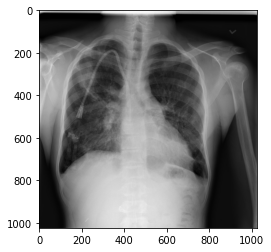

In [0]:
plt.imshow(train[10])

In [6]:
#computing means and SDs
ch1 =[]
ch2 =[]
ch3= []
SD1 = []
SD2 =[]
SD3=[]
for i in range(len(train)):
    ch1.append(((train[i][:][:][0])/255).mean())
    SD1.append(((np.std(train[i][:][:][0])/255)))
    ch2.append(((train[i][:][:][1])/255).mean())
    SD2.append(((np.std(train[i][:][:][1])/255)))
    ch3.append(((train[i][:][:][2])/255).mean())
    SD3.append(((np.std(train[i][:][:][2])/255)))

print(sum(ch1)/len(train))
print(sum(ch2)/len(train))
print(sum(ch3)/len(train))
print(sum(SD1)/len(train))
print(sum(SD2)/len(train))
print(sum(SD3)/len(train))

0.2522823937719977
0.2939528145251096
0.28813030660139644
0.1468407413404912
0.19197234296991345
0.19362933258173468


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
def getAccuracy(givenData, cnn):
    correct = 0
    total = 0
    pr =[]
    tl =[]
    confMatrix = torch.zeros(2,2)
    with torch.no_grad():
        for data in givenData:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            if cnn == "resnet":
                outputs = resnet18(images)
            elif cnn == "vgg":
                outputs = vgg16(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            acc = (100 * correct / total)

            for i in labels.tolist():
                tl.append(i)
            for j in predicted.tolist():
                pr.append(j)
    # print(">>", confMatrix)
    # print(tl)

    print("confusion_matrix\n ",confusion_matrix(tl,pr))   
    print("f1_score",f1_score(tl,pr))
    return acc, loss.item()
def plot(tacc, tloss, vacc, vloss):
    plt.plot(range(len(tloss)), tloss, label = 'Training loss curve')
    plt.legend()
    plt.title('loss curves')
    plt.plot(range(len(vloss)), vloss, label = 'Validation loss curve')
    plt.legend()
    plt.xlabel('Epochs') 
    plt.ylabel('Entropy Loss') 
    plt.show()

    plt.plot(range(len(tacc)), tacc, label = 'Trainging accuracy')
    plt.plot(range(len(vacc)), vacc, label = 'Validation accuracy')
    plt.legend()
    plt.title('Accuracy curves')
    plt.xlabel('Epochs') 
    plt.ylabel('Accuracy') 
    plt.show()

In [5]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(30),
                                       transforms.Resize(224),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.252, 0.293, 0.288],
                                                            [0.146, 0.191, 0.193])])

test_transforms = transforms.Compose([
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                       transforms.Normalize([0.252, 0.293, 0.288],
                                                            [0.146, 0.191, 0.193])])

valid_transforms = transforms.Compose([
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                       transforms.Normalize([0.252, 0.293, 0.288],
                                                            [0.146, 0.191, 0.193])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/validation', transform=valid_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=12, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=12, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=12, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


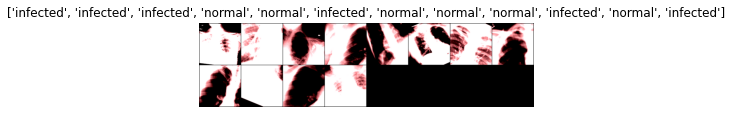

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# VGG16_ONLY (PART1)

In [39]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
# print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# print(vgg16.classifier[3])
vgg16.classifier[0].out_features = 370
vgg16.classifier[3].in_features = 370
vgg16.classifier[3].out_features = 2
# vgg16.classifier[4] = nn. Softmax(dim=1)#nn.LogSigmoid()

In [41]:
#removing last layer
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-3] # Remove last layer
print(features)

[Linear(in_features=25088, out_features=370, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=370, out_features=2, bias=True)]


In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [0]:
#adding new layer
# features.extend([nn.Linear(num_features, len(class_names))])

In [44]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
#loss function and optimizer
Epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0015, momentum=0.5)

In [46]:
#Training
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
trainAccuracy =[]
validAccuracy = []
TrainLoss =[]
ValidLoss=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth')
    tacc, tloss = getAccuracy(trainloader, "vgg")
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    vacc , vloss = getAccuracy(validloader, "vgg")
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
    print("\n>>tacc, tloss, vacc , vloss\n",tacc, tloss, vacc , vloss )
print('Finished Training')

Train Epoch: 0 [1008/1120 (90%)]	Loss: 0.813823: : 10it [00:31,  3.12s/it]


confusion_matrix  [[200 280]
 [ 93 547]]
f1_score 0.7457396046353102


0it [00:00, ?it/s]

confusion_matrix  [[295 320]
 [ 74 417]]
f1_score 0.6791530944625407

>>tacc, tloss, vacc , vloss
 66.69642857142857 0.8461831212043762 64.376130198915 0.7997299432754517


Train Epoch: 1 [1008/1120 (90%)]	Loss: 0.559732: : 10it [00:31,  3.11s/it]


confusion_matrix  [[298 182]
 [ 91 549]]
f1_score 0.8008752735229758


0it [00:00, ?it/s]

confusion_matrix  [[391 224]
 [ 85 406]]
f1_score 0.7243532560214095

>>tacc, tloss, vacc , vloss
 75.625 0.5738162398338318 72.0614828209765 0.5485129356384277


Train Epoch: 2 [1008/1120 (90%)]	Loss: 0.527168: : 10it [00:31,  3.12s/it]


confusion_matrix  [[352 128]
 [129 511]]
f1_score 0.7990617670054729


0it [00:00, ?it/s]

confusion_matrix  [[478 137]
 [121 370]]
f1_score 0.7414829659318638

>>tacc, tloss, vacc , vloss
 77.05357142857143 0.5797719955444336 76.67269439421338 0.4949916899204254


Train Epoch: 3 [1008/1120 (90%)]	Loss: 0.493230: : 10it [00:31,  3.14s/it]


confusion_matrix  [[316 164]
 [ 71 569]]
f1_score 0.8288419519300801


0it [00:00, ?it/s]

confusion_matrix  [[399 216]
 [ 70 421]]
f1_score 0.7464539007092199

>>tacc, tloss, vacc , vloss
 79.01785714285714 0.4480677545070648 74.14104882459313 0.4310140311717987


Train Epoch: 4 [1008/1120 (90%)]	Loss: 0.405647: : 10it [00:31,  3.12s/it]


confusion_matrix  [[347 133]
 [111 529]]
f1_score 0.8125960061443932


0it [00:00, ?it/s]

confusion_matrix  [[458 157]
 [ 96 395]]
f1_score 0.7574304889741131

>>tacc, tloss, vacc , vloss
 78.21428571428571 0.43264177441596985 77.124773960217 0.615705668926239


Train Epoch: 5 [1008/1120 (90%)]	Loss: 0.587968: : 10it [00:31,  3.16s/it]


confusion_matrix  [[367 113]
 [ 97 543]]
f1_score 0.8379629629629629


0it [00:00, ?it/s]

confusion_matrix  [[466 149]
 [103 388]]
f1_score 0.754863813229572

>>tacc, tloss, vacc , vloss
 81.25 0.39317065477371216 77.21518987341773 0.4373759925365448


Train Epoch: 6 [1008/1120 (90%)]	Loss: 0.397507: : 10it [00:31,  3.14s/it]


confusion_matrix  [[342 138]
 [ 80 560]]
f1_score 0.8370702541106128


0it [00:00, ?it/s]

confusion_matrix  [[444 171]
 [ 70 421]]
f1_score 0.7774699907663897

>>tacc, tloss, vacc , vloss
 80.53571428571429 0.5158203840255737 78.20976491862568 0.5290036201477051


Train Epoch: 7 [1008/1120 (90%)]	Loss: 0.451846: : 10it [00:31,  3.14s/it]


confusion_matrix  [[368 112]
 [113 527]]
f1_score 0.8240813135261924


0it [00:00, ?it/s]

confusion_matrix  [[464 151]
 [ 91 400]]
f1_score 0.7677543186180422

>>tacc, tloss, vacc , vloss
 79.91071428571429 0.436355859041214 78.11934900542495 0.6102451086044312


Train Epoch: 8 [1008/1120 (90%)]	Loss: 0.373585: : 10it [00:31,  3.15s/it]


confusion_matrix  [[337 143]
 [ 70 570]]
f1_score 0.8425720620842573


0it [00:00, ?it/s]

confusion_matrix  [[433 182]
 [ 66 425]]
f1_score 0.7741347905282332

>>tacc, tloss, vacc , vloss
 80.98214285714286 0.41216322779655457 77.57685352622062 0.4958235025405884


Train Epoch: 9 [1008/1120 (90%)]	Loss: 0.435147: : 10it [00:31,  3.14s/it]


confusion_matrix  [[372 108]
 [121 519]]
f1_score 0.819258089976322


0it [00:00, ?it/s]

confusion_matrix  [[496 119]
 [107 384]]
f1_score 0.772635814889336

>>tacc, tloss, vacc , vloss
 79.55357142857143 0.5123718976974487 79.56600361663652 0.3454653322696686


Train Epoch: 10 [1008/1120 (90%)]	Loss: 0.375715: : 10it [00:31,  3.14s/it]


confusion_matrix  [[350 130]
 [ 90 550]]
f1_score 0.8333333333333333


0it [00:00, ?it/s]

confusion_matrix  [[473 142]
 [ 82 409]]
f1_score 0.7850287907869481

>>tacc, tloss, vacc , vloss
 80.35714285714286 0.4112977385520935 79.74683544303798 0.5853220820426941


Train Epoch: 11 [1008/1120 (90%)]	Loss: 0.502277: : 10it [00:31,  3.15s/it]


confusion_matrix  [[376 104]
 [ 95 545]]
f1_score 0.8456167571761055


0it [00:00, ?it/s]

confusion_matrix  [[486 129]
 [ 91 400]]
f1_score 0.7843137254901961

>>tacc, tloss, vacc , vloss
 82.23214285714286 0.3698265850543976 80.10849909584087 0.4319038689136505


Train Epoch: 12 [1008/1120 (90%)]	Loss: 0.449615: : 10it [00:31,  3.13s/it]


confusion_matrix  [[374 106]
 [ 80 560]]
f1_score 0.8575803981623278


0it [00:00, ?it/s]

confusion_matrix  [[487 128]
 [ 83 408]]
f1_score 0.7945472249269716

>>tacc, tloss, vacc , vloss
 83.39285714285714 0.41881003975868225 80.92224231464738 0.4272879660129547


Train Epoch: 13 [1008/1120 (90%)]	Loss: 0.395499: : 10it [00:32,  3.28s/it]


confusion_matrix  [[392  88]
 [129 511]]
f1_score 0.824858757062147


0it [00:00, ?it/s]

confusion_matrix  [[519  96]
 [121 370]]
f1_score 0.7732497387669801

>>tacc, tloss, vacc , vloss
 80.625 0.588072657585144 80.37974683544304 0.3718963861465454


Train Epoch: 14 [1008/1120 (90%)]	Loss: 0.403706: : 10it [00:32,  3.26s/it]


confusion_matrix  [[384  96]
 [101 539]]
f1_score 0.8454901960784313
confusion_matrix  [[498 117]
 [100 391]]
f1_score 0.7827827827827828

>>tacc, tloss, vacc , vloss
 82.41071428571429 0.4419100880622864 80.37974683544304 0.5393247604370117
Finished Training


In [47]:
print(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)

[66.69642857142857, 75.625, 77.05357142857143, 79.01785714285714, 78.21428571428571, 81.25, 80.53571428571429, 79.91071428571429, 80.98214285714286, 79.55357142857143, 80.35714285714286, 82.23214285714286, 83.39285714285714, 80.625, 82.41071428571429] [0.8461831212043762, 0.5738162398338318, 0.5797719955444336, 0.4480677545070648, 0.43264177441596985, 0.39317065477371216, 0.5158203840255737, 0.436355859041214, 0.41216322779655457, 0.5123718976974487, 0.4112977385520935, 0.3698265850543976, 0.41881003975868225, 0.588072657585144, 0.4419100880622864] [64.376130198915, 72.0614828209765, 76.67269439421338, 74.14104882459313, 77.124773960217, 77.21518987341773, 78.20976491862568, 78.11934900542495, 77.57685352622062, 79.56600361663652, 79.74683544303798, 80.10849909584087, 80.92224231464738, 80.37974683544304, 80.37974683544304] [0.7997299432754517, 0.5485129356384277, 0.4949916899204254, 0.4310140311717987, 0.615705668926239, 0.4373759925365448, 0.5290036201477051, 0.6102451086044312, 0.49

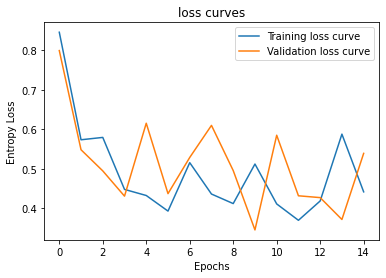

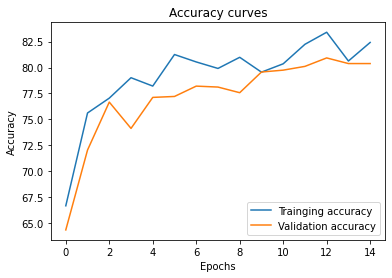

In [48]:
plot(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)

# Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


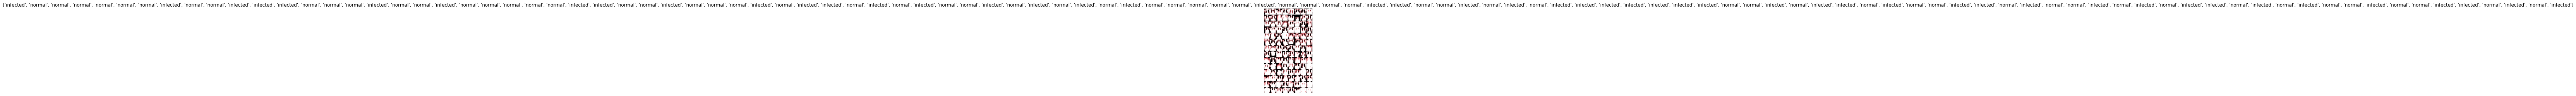

In [51]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [52]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal normal normal normal normal infected infected normal infected infected infected infected normal normal normal normal normal infected infected normal normal normal normal infected normal normal infected infected normal normal normal infected normal infected infected normal infected infected infected normal normal infected normal infected normal normal normal infected normal normal normal normal normal infected normal normal normal normal infected infected infected normal infected normal infected normal infected infected infected infected infected infected infected infected normal infected normal infected infected normal infected normal normal infected infected normal infected infected normal infected normal infected normal infected infected normal infected normal infected normal normal infected infected normal infected infected normal infected normal infected
Ground Truth:  infected normal normal normal normal normal normal infected normal normal infecte

In [53]:
correct = 0
total = 0
tl=[]
pr=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in labels.tolist():
            tl.append(i)
        for j in predicted.tolist():
            pr.append(j)

    print("confusion_matrix \n",confusion_matrix(tl,pr))   
    print("f1_score",f1_score(tl,pr))
print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

confusion_matrix 
 [[528  84]
 [ 59 589]]
f1_score 0.8917486752460259
Accuracy of the network on test images: 88 %


# VGG16_ENTIRE (PART2)

Unfreezing 1st conv layer

In [7]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
# print(vgg16)
#...............
# print(vgg16.classifier[3])
vgg16.classifier[0].out_features = 370
vgg16.classifier[3].in_features = 370
vgg16.classifier[3].out_features = 2
# vgg16.classifier[4] = nn. Softmax(dim=1)#nn.LogSigmoid()
#...............
#removing last layer
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-3] # Remove last layer
print(features)
#...............
# Freeze training for all layers except 1
for param in vgg16.features[1:].parameters():
    param.requires_grad = False
#...............
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



[Linear(in_features=25088, out_features=370, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=370, out_features=2, bias=True)]
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Co

In [8]:
#loss function and optimizer
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
#Training
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
trainAccuracy =[]
validAccuracy = []
TrainLoss =[]
ValidLoss=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(vgg16.state_dict(), 'vgg16_entire.pth')
    print("Training stats \n")
    tacc, tloss = getAccuracy(trainloader, "vgg")
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    print("validation stats\n")
    vacc , vloss = getAccuracy(validloader, "vgg")
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
    print("\n>>",tacc, tloss, vacc , vloss )
print('Finished Training')

Train Epoch: 0 [372/1120 (99%)]	Loss: 0.195802: : 94it [00:32,  2.85it/s]


Training stats 

confusion_matrix
  [[162 318]
 [ 24 616]]
f1_score 0.7827191867852605
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[327 288]
 [ 34 457]]
f1_score 0.7394822006472492

>> 69.46428571428571 0.38152408599853516 70.88607594936708 0.4356966018676758


Train Epoch: 1 [372/1120 (99%)]	Loss: 0.089083: : 94it [00:32,  2.88it/s]


Training stats 

confusion_matrix
  [[282 198]
 [ 44 596]]
f1_score 0.8312412831241284
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[409 206]
 [ 52 439]]
f1_score 0.772887323943662

>> 78.39285714285714 0.6882979869842529 76.67269439421338 2.1422042846679688


Train Epoch: 2 [372/1120 (99%)]	Loss: 0.919942: : 94it [00:32,  2.86it/s]


Training stats 

confusion_matrix
  [[310 170]
 [ 67 573]]
f1_score 0.8286334056399132
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[375 240]
 [ 38 453]]
f1_score 0.7652027027027026

>> 78.83928571428571 0.6776249408721924 74.86437613019892 0.033050537109375


Train Epoch: 3 [372/1120 (99%)]	Loss: 0.253832: : 94it [00:32,  2.88it/s]


Training stats 

confusion_matrix
  [[395  85]
 [151 489]]
f1_score 0.8056013179571663
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[497 118]
 [ 85 406]]
f1_score 0.8

>> 78.92857142857143 1.3212015628814697 81.64556962025317 0.2531609535217285


Train Epoch: 4 [372/1120 (99%)]	Loss: 0.273258: : 94it [00:32,  2.88it/s]


Training stats 

confusion_matrix
  [[376 104]
 [117 523]]
f1_score 0.8255722178374111
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[472 143]
 [ 66 425]]
f1_score 0.8026440037771481

>> 80.26785714285714 0.4443786144256592 81.10307414104882 0.004767894744873047


Train Epoch: 5 [372/1120 (99%)]	Loss: 0.290629: : 94it [00:32,  2.88it/s]


Training stats 

confusion_matrix
  [[338 142]
 [ 84 556]]
f1_score 0.8310911808669655
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[442 173]
 [ 60 431]]
f1_score 0.7872146118721461

>> 79.82142857142857 0.03861117362976074 78.93309222423146 0.6851248741149902


Train Epoch: 6 [372/1120 (99%)]	Loss: 0.119692: : 94it [00:32,  2.88it/s]


Training stats 

confusion_matrix
  [[297 183]
 [ 39 601]]
f1_score 0.8441011235955056
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[445 170]
 [ 53 438]]
f1_score 0.7970882620564149

>> 80.17857142857143 0.4389333724975586 79.8372513562387 0.11632680892944336


Train Epoch: 7 [372/1120 (99%)]	Loss: 0.167842: : 94it [00:32,  2.88it/s]


Training stats 

confusion_matrix
  [[360 120]
 [ 78 562]]
f1_score 0.8502269288956129
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[491 124]
 [ 85 406]]
f1_score 0.7952987267384917

>> 82.32142857142857 0.07802724838256836 81.10307414104882 0.2719554901123047


Train Epoch: 8 [372/1120 (99%)]	Loss: 1.147954: : 94it [00:32,  2.89it/s]


Training stats 

confusion_matrix
  [[333 147]
 [ 42 598]]
f1_score 0.8635379061371842
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[427 188]
 [ 46 445]]
f1_score 0.791814946619217

>> 83.125 0.7664999961853027 78.84267631103074 0.37241172790527344


Train Epoch: 9 [372/1120 (99%)]	Loss: 0.127920: : 94it [00:32,  2.88it/s]


Training stats 

confusion_matrix
  [[299 181]
 [ 30 610]]
f1_score 0.8525506638714186
validation stats

confusion_matrix
  [[463 152]
 [ 59 432]]
f1_score 0.803720930232558

>> 81.16071428571429 0.4681510925292969 80.92224231464738 0.03616189956665039
Finished Training


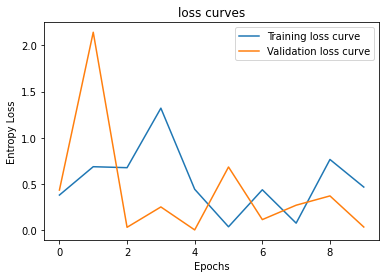

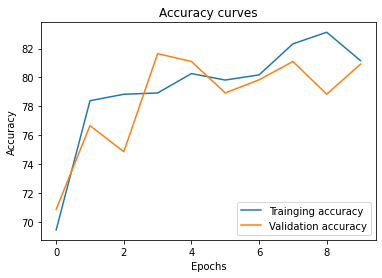

confusion_matrix 
 [[498 114]
 [ 28 620]]
f1_score 0.8972503617945008
Accuracy of the network on test images: 88 %


In [9]:
plot(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)
correct = 0
total = 0
tl=[]
pr=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in labels.tolist():
            tl.append(i)
        for j in predicted.tolist():
            pr.append(j)

    print("confusion_matrix \n",confusion_matrix(tl,pr))   
    print("f1_score",f1_score(tl,pr))
print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

unfreezing 2 conv layers

In [7]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
# print(vgg16)
#...............
# print(vgg16.classifier[3])
vgg16.classifier[0].out_features = 370
vgg16.classifier[3].in_features = 370
vgg16.classifier[3].out_features = 2
# vgg16.classifier[4] = nn. Softmax(dim=1)#nn.LogSigmoid()
#...............
#removing last layer
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-3] # Remove last layer
print(features)
#...............
# Freeze training for all layers except 1
for param in vgg16.features[3:].parameters():
    param.requires_grad = False
#...............
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



[Linear(in_features=25088, out_features=370, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=370, out_features=2, bias=True)]
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Co

In [8]:
#loss function and optimizer
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
#Training
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
trainAccuracy =[]
validAccuracy = []
TrainLoss =[]
ValidLoss=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(vgg16.state_dict(), 'vgg16_entire.pth')
    print("Training stats \n")
    tacc, tloss = getAccuracy(trainloader, "vgg")
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    print("validation stats\n")
    vacc , vloss = getAccuracy(validloader, "vgg")
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
    print("\n>>tacc, tloss, vacc , vloss\n",tacc, tloss, vacc , vloss )
print('Finished Training')

Train Epoch: 0 [372/1120 (99%)]	Loss: 0.791955: : 94it [00:40,  2.34it/s]


Training stats 

confusion_matrix
  [[190 290]
 [ 25 615]]
f1_score 0.7961165048543689
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[307 308]
 [ 42 449]]
f1_score 0.7195512820512819

>>tacc, tloss, vacc , vloss
 71.875 1.1604790687561035 68.35443037974683 0.4563751220703125


Train Epoch: 1 [372/1120 (99%)]	Loss: 0.391074: : 94it [00:41,  2.25it/s]


Training stats 

confusion_matrix
  [[446  34]
 [310 330]]
f1_score 0.6573705179282868
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[557  58]
 [157 334]]
f1_score 0.7565118912797283

>>tacc, tloss, vacc , vloss
 69.28571428571429 0.703449010848999 80.56057866184449 0.023221969604492188


Train Epoch: 2 [372/1120 (99%)]	Loss: 2.430857: : 94it [00:41,  2.27it/s]


Training stats 

confusion_matrix
  [[368 112]
 [ 98 542]]
f1_score 0.8377125193199381
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[506 109]
 [ 93 398]]
f1_score 0.7975951903807615

>>tacc, tloss, vacc , vloss
 81.25 0.28292393684387207 81.73598553345388 0.004137992858886719


Train Epoch: 3 [372/1120 (99%)]	Loss: 0.024489: : 94it [00:41,  2.26it/s]


Training stats 

confusion_matrix
  [[329 151]
 [ 58 582]]
f1_score 0.8477785870356883
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[418 197]
 [ 55 436]]
f1_score 0.7758007117437723

>>tacc, tloss, vacc , vloss
 81.33928571428571 0.9142887592315674 77.21518987341773 0.10354328155517578


Train Epoch: 4 [372/1120 (99%)]	Loss: 0.106123: : 94it [00:41,  2.25it/s]


Training stats 

confusion_matrix
  [[397  83]
 [106 534]]
f1_score 0.8496420047732697
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[513 102]
 [112 379]]
f1_score 0.779835390946502

>>tacc, tloss, vacc , vloss
 83.125 0.6815826892852783 80.6509945750452 0.794062614440918


Train Epoch: 5 [372/1120 (99%)]	Loss: 0.022759: : 94it [00:41,  2.26it/s]


Training stats 

confusion_matrix
  [[366 114]
 [ 70 570]]
f1_score 0.8610271903323262
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[486 129]
 [ 66 425]]
f1_score 0.8133971291866028

>>tacc, tloss, vacc , vloss
 83.57142857142857 0.09108757972717285 82.36889692585895 0.037398338317871094


Train Epoch: 6 [372/1120 (99%)]	Loss: 0.208113: : 94it [00:41,  2.26it/s]


Training stats 

confusion_matrix
  [[363 117]
 [ 74 566]]
f1_score 0.8556311413454271
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[514 101]
 [ 92 399]]
f1_score 0.805247225025227

>>tacc, tloss, vacc , vloss
 82.94642857142857 1.764387607574463 82.54972875226039 0.03180980682373047


Train Epoch: 7 [372/1120 (99%)]	Loss: 0.296494: : 94it [00:41,  2.26it/s]


Training stats 

confusion_matrix
  [[271 209]
 [ 32 608]]
f1_score 0.8345916266300618
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[435 180]
 [ 38 453]]
f1_score 0.8060498220640568

>>tacc, tloss, vacc , vloss
 78.48214285714286 0.12589550018310547 80.28933092224231 0.06367826461791992


Train Epoch: 8 [372/1120 (99%)]	Loss: 0.302859: : 94it [00:41,  2.26it/s]


Training stats 

confusion_matrix
  [[392  88]
 [ 99 541]]
f1_score 0.8526398739164697
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[533  82]
 [103 388]]
f1_score 0.8074921956295525

>>tacc, tloss, vacc , vloss
 83.30357142857143 0.11551260948181152 83.27305605786619 0.03564262390136719


Train Epoch: 9 [372/1120 (99%)]	Loss: 0.052637: : 94it [00:41,  2.26it/s]


Training stats 

confusion_matrix
  [[306 174]
 [ 33 607]]
f1_score 0.8543279380717805
validation stats

confusion_matrix
  [[442 173]
 [ 56 435]]
f1_score 0.791628753412193

>>tacc, tloss, vacc , vloss
 81.51785714285714 0.3627634048461914 79.29475587703436 1.0854673385620117
Finished Training


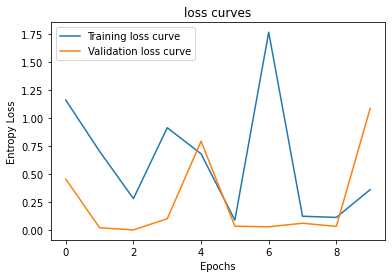

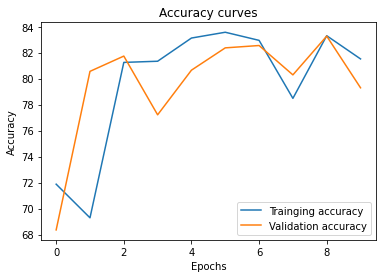

confusion_matrix 
 [[491 121]
 [ 26 622]]
f1_score 0.8943206326383897
Accuracy of the network on test images: 88 %


In [9]:
plot(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)
correct = 0
total = 0
tl=[]
pr=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in labels.tolist():
            tl.append(i)
        for j in predicted.tolist():
            pr.append(j)

    print("confusion_matrix \n",confusion_matrix(tl,pr))   
    print("f1_score",f1_score(tl,pr))
print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

unfreezing half ayers

In [7]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
# print(vgg16)
#...............
# print(vgg16.classifier[3])
vgg16.classifier[0].out_features = 370
vgg16.classifier[3].in_features = 370
vgg16.classifier[3].out_features = 2
# vgg16.classifier[4] = nn. Softmax(dim=1)#nn.LogSigmoid()
#...............
#removing last layer
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-3] # Remove last layer
print(features)
#...............
# Freeze training for all layers except 1
for param in vgg16.features[15:].parameters():
    param.requires_grad = False
#...............
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



[Linear(in_features=25088, out_features=370, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=370, out_features=2, bias=True)]
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Co

In [8]:
#loss function and optimizer
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
#Training
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
trainAccuracy =[]
validAccuracy = []
TrainLoss =[]
ValidLoss=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(vgg16.state_dict(), 'vgg16_entire.pth')
    print("Training stats \n")
    tacc, tloss = getAccuracy(trainloader, "vgg")
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    print("validation stats\n")
    vacc , vloss = getAccuracy(validloader, "vgg")
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
    print("\n>>tacc, tloss, vacc , vloss\n",tacc, tloss, vacc , vloss ,"\n.......................................\n")
print('Finished Training')

Train Epoch: 0 [372/1120 (99%)]	Loss: 0.844089: : 94it [00:42,  2.24it/s]


Training stats 

confusion_matrix
  [[369 111]
 [220 420]]
f1_score 0.71733561058924
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[516  99]
 [174 317]]
f1_score 0.6990077177508269

>>tacc, tloss, vacc , vloss
 70.44642857142857 0.360990047454834 75.31645569620254 0.12494468688964844 
.......................................



Train Epoch: 1 [372/1120 (99%)]	Loss: 1.186882: : 94it [00:42,  2.24it/s]


Training stats 

confusion_matrix
  [[412  68]
 [197 443]]
f1_score 0.7697654213727194
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[521  94]
 [166 325]]
f1_score 0.7142857142857143

>>tacc, tloss, vacc , vloss
 76.33928571428571 0.4234297275543213 76.49186256781194 0.018265724182128906 
.......................................



Train Epoch: 2 [372/1120 (99%)]	Loss: 1.073607: : 94it [00:43,  2.18it/s]


Training stats 

confusion_matrix
  [[343 137]
 [ 63 577]]
f1_score 0.8522895125553915
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[505 110]
 [ 84 407]]
f1_score 0.8075396825396826

>>tacc, tloss, vacc , vloss
 82.14285714285714 0.4562532901763916 82.45931283905968 0.15111827850341797 
.......................................



Train Epoch: 3 [372/1120 (99%)]	Loss: 0.077461: : 94it [00:42,  2.20it/s]


Training stats 

confusion_matrix
  [[215 265]
 [ 18 622]]
f1_score 0.8146692861820564
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[342 273]
 [ 20 471]]
f1_score 0.7627530364372469

>>tacc, tloss, vacc , vloss
 74.73214285714286 0.1090240478515625 73.50813743218806 0.491544246673584 
.......................................



Train Epoch: 4 [372/1120 (99%)]	Loss: 0.189636: : 94it [00:42,  2.19it/s]


Training stats 

confusion_matrix
  [[414  66]
 [143 497]]
f1_score 0.8262676641729012
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[557  58]
 [125 366]]
f1_score 0.7999999999999999

>>tacc, tloss, vacc , vloss
 81.33928571428571 1.6596791744232178 83.45388788426763 1.396742820739746 
.......................................



Train Epoch: 5 [372/1120 (99%)]	Loss: 0.222500: : 94it [00:43,  2.18it/s]


Training stats 

confusion_matrix
  [[410  70]
 [136 504]]
f1_score 0.830313014827018
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[538  77]
 [ 93 398]]
f1_score 0.8240165631469979

>>tacc, tloss, vacc , vloss
 81.60714285714286 0.5257964134216309 84.62929475587704 0.10123395919799805 
.......................................



Train Epoch: 6 [372/1120 (99%)]	Loss: 0.797234: : 94it [00:43,  2.17it/s]


Training stats 

confusion_matrix
  [[416  64]
 [124 516]]
f1_score 0.8459016393442622
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[568  47]
 [146 345]]
f1_score 0.7814269535673839

>>tacc, tloss, vacc , vloss
 83.21428571428571 0.8748095035552979 82.54972875226039 0.1892833709716797 
.......................................



Train Epoch: 7 [372/1120 (99%)]	Loss: 0.259835: : 94it [00:43,  2.18it/s]


Training stats 

confusion_matrix
  [[282 198]
 [ 12 628]]
f1_score 0.8567530695770805
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[439 176]
 [ 39 452]]
f1_score 0.807864164432529

>>tacc, tloss, vacc , vloss
 81.25 0.44524693489074707 80.56057866184449 1.6327447891235352 
.......................................



Train Epoch: 8 [372/1120 (99%)]	Loss: 0.944534: : 94it [00:43,  2.17it/s]


Training stats 

confusion_matrix
  [[408  72]
 [115 525]]
f1_score 0.8488278092158448
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[578  37]
 [181 310]]
f1_score 0.7398568019093078

>>tacc, tloss, vacc , vloss
 83.30357142857143 0.31156468391418457 80.28933092224231 0.3832130432128906 
.......................................



Train Epoch: 9 [372/1120 (99%)]	Loss: 0.259985: : 94it [00:43,  2.18it/s]


Training stats 

confusion_matrix
  [[307 173]
 [ 20 620]]
f1_score 0.8653175157013259
validation stats

confusion_matrix
  [[369 246]
 [ 19 472]]
f1_score 0.7808105872622002

>>tacc, tloss, vacc , vloss
 82.76785714285714 0.021315336227416992 76.03978300180832 3.3569822311401367 
.......................................

Finished Training


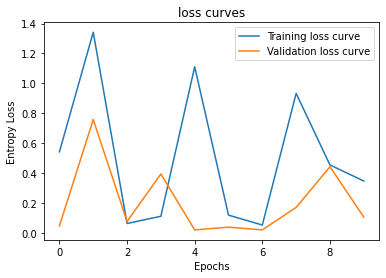

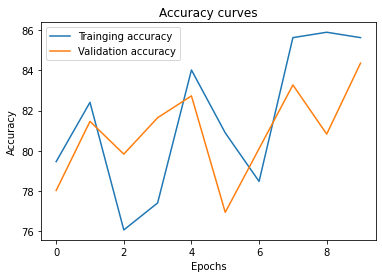

Accuracy of the network on test images: 90 %


In [0]:
plot(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)
correct = 0
total = 0
tl=[]
pr=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in labels.tolist():
            tl.append(i)
        for j in predicted.tolist():
            pr.append(j)

    print("confusion_matrix \n",confusion_matrix(tl,pr))   
    print("f1_score",f1_score(tl,pr))
print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Entire

In [7]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
# print(vgg16)
#...............
# print(vgg16.classifier[3])
# vgg16.classifier[0].out_features = 370
vgg16.classifier[6].in_features = 370
vgg16.classifier[6].out_features = 2
# vgg16.classifier[4] = nn. Softmax(dim=1)#nn.LogSigmoid()
#...............
#removing last layer
# num_features = vgg16.classifier[6].in_features
# features = list(vgg16.classifier.children())[:-3] # Remove last layer
# print(features)
# #...............
# for param in vgg16.features.parameters():
#     param.requires_grad = True
#...............
# vgg16.classifier = nn.Sequential(*features)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
#loss function and optimizer
Epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0015, momentum=0.9)

In [9]:
#Training
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
trainAccuracy =[]
validAccuracy = []
TrainLoss =[]
ValidLoss=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(vgg16.state_dict(), 'vgg16_entire.pth')
    print("Training stats \n")
    tacc, tloss = getAccuracy(trainloader, "vgg")
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    print("validation stats\n")
    vacc , vloss = getAccuracy(validloader, "vgg")
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
    print("\n>>tacc, tloss, vacc , vloss\n",tacc, tloss, vacc , vloss ,"\n............................\n")
print('Finished Training')

Train Epoch: 0 [372/1120 (99%)]	Loss: 0.693784: : 94it [00:35,  2.66it/s]


Training stats 

confusion_matrix
  [[ 95 385]
 [ 34 606]]
f1_score 0.7431023911710607
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[217 398]
 [ 37 454]]
f1_score 0.6760982874162323

>>tacc, tloss, vacc , vloss
 62.589285714285715 0.2546045780181885 60.66907775768535 0.6765422821044922 
............................



Train Epoch: 1 [372/1120 (99%)]	Loss: 0.663007: : 94it [00:34,  2.70it/s]


Training stats 

confusion_matrix
  [[229 251]
 [ 40 600]]
f1_score 0.8048289738430583
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[333 282]
 [ 38 453]]
f1_score 0.7389885807504077

>>tacc, tloss, vacc , vloss
 74.01785714285714 0.21030068397521973 71.06690777576854 0.19913482666015625 
............................



Train Epoch: 2 [372/1120 (99%)]	Loss: 0.503847: : 94it [00:34,  2.69it/s]


Training stats 

confusion_matrix
  [[372 108]
 [ 96 544]]
f1_score 0.8421052631578947
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[542  73]
 [130 361]]
f1_score 0.7805405405405407

>>tacc, tloss, vacc , vloss
 81.78571428571429 0.23437976837158203 81.64556962025317 0.07639837265014648 
............................



Train Epoch: 3 [372/1120 (99%)]	Loss: 0.386624: : 94it [00:34,  2.70it/s]


Training stats 

confusion_matrix
  [[350 130]
 [ 43 597]]
f1_score 0.8734455010972934
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[497 118]
 [ 51 440]]
f1_score 0.8388941849380364

>>tacc, tloss, vacc , vloss
 84.55357142857143 1.0505764484405518 84.71971066907776 0.0350956916809082 
............................



Train Epoch: 4 [372/1120 (99%)]	Loss: 0.370056: : 94it [00:34,  2.70it/s]


Training stats 

confusion_matrix
  [[177 303]
 [ 16 624]]
f1_score 0.7964262922782386
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[268 347]
 [  7 484]]
f1_score 0.7322239031770046

>>tacc, tloss, vacc , vloss
 71.51785714285714 0.90006422996521 67.99276672694394 1.2822628021240234 
............................



Train Epoch: 5 [372/1120 (99%)]	Loss: 0.568603: : 94it [00:35,  2.68it/s]


Training stats 

confusion_matrix
  [[381  99]
 [ 63 577]]
f1_score 0.8768996960486323
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[515 100]
 [ 62 429]]
f1_score 0.8411764705882353

>>tacc, tloss, vacc , vloss
 85.53571428571429 0.37424492835998535 85.35262206148282 0.29442739486694336 
............................



Train Epoch: 6 [372/1120 (99%)]	Loss: 0.399555: : 94it [00:34,  2.69it/s]


Training stats 

confusion_matrix
  [[378 102]
 [ 68 572]]
f1_score 0.8706240487062404
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[498 117]
 [ 56 435]]
f1_score 0.8341323106423776

>>tacc, tloss, vacc , vloss
 84.82142857142857 0.11248588562011719 84.35804701627487 0.13878822326660156 
............................



Train Epoch: 7 [372/1120 (99%)]	Loss: 0.433588: : 94it [00:34,  2.71it/s]


Training stats 

confusion_matrix
  [[321 159]
 [ 14 626]]
f1_score 0.8785964912280702
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[438 177]
 [ 25 466]]
f1_score 0.8218694885361552

>>tacc, tloss, vacc , vloss
 84.55357142857143 0.42276954650878906 81.73598553345388 1.168870449066162 
............................



Train Epoch: 8 [372/1120 (99%)]	Loss: 0.329805: : 94it [00:34,  2.69it/s]


Training stats 

confusion_matrix
  [[353 127]
 [ 31 609]]
f1_score 0.8851744186046512
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[448 167]
 [ 24 467]]
f1_score 0.8302222222222222

>>tacc, tloss, vacc , vloss
 85.89285714285714 1.5556015968322754 82.73056057866185 0.08941173553466797 
............................



Train Epoch: 9 [372/1120 (99%)]	Loss: 0.238847: : 94it [00:35,  2.68it/s]


Training stats 

confusion_matrix
  [[433  47]
 [103 537]]
f1_score 0.877450980392157
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[556  59]
 [ 78 413]]
f1_score 0.8577362409138111

>>tacc, tloss, vacc , vloss
 86.60714285714286 0.7263503074645996 87.6130198915009 0.22021865844726562 
............................



Train Epoch: 10 [372/1120 (99%)]	Loss: 0.892176: : 94it [00:35,  2.65it/s]


Training stats 

confusion_matrix
  [[372 108]
 [ 56 584]]
f1_score 0.8768768768768769
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[494 121]
 [ 42 449]]
f1_score 0.8463713477851084

>>tacc, tloss, vacc , vloss
 85.35714285714286 0.13470220565795898 85.2622061482821 0.0749664306640625 
............................



Train Epoch: 11 [372/1120 (99%)]	Loss: 0.297515: : 94it [00:35,  2.63it/s]


Training stats 

confusion_matrix
  [[395  85]
 [ 73 567]]
f1_score 0.8777089783281733
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[507 108]
 [ 55 436]]
f1_score 0.842512077294686

>>tacc, tloss, vacc , vloss
 85.89285714285714 0.4403834342956543 85.2622061482821 1.7801079750061035 
............................



Train Epoch: 12 [372/1120 (99%)]	Loss: 0.366673: : 94it [00:35,  2.65it/s]


Training stats 

confusion_matrix
  [[433  47]
 [ 98 542]]
f1_score 0.8820179007323028
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[554  61]
 [ 75 416]]
f1_score 0.859504132231405

>>tacc, tloss, vacc , vloss
 87.05357142857143 0.1990206241607666 87.70343580470163 0.03946638107299805 
............................



Train Epoch: 13 [372/1120 (99%)]	Loss: 0.203622: : 94it [00:34,  2.69it/s]


Training stats 

confusion_matrix
  [[368 112]
 [ 33 607]]
f1_score 0.8933038999264166
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[493 122]
 [ 39 452]]
f1_score 0.8488262910798122

>>tacc, tloss, vacc , vloss
 87.05357142857143 0.03268909454345703 85.44303797468355 0.01689291000366211 
............................



Train Epoch: 14 [372/1120 (99%)]	Loss: 0.097528: : 94it [00:34,  2.69it/s]


Training stats 

confusion_matrix
  [[438  42]
 [ 72 568]]
f1_score 0.9087999999999999
validation stats

confusion_matrix
  [[533  82]
 [ 45 446]]
f1_score 0.8753680078508341

>>tacc, tloss, vacc , vloss
 89.82142857142857 0.317457914352417 88.51717902350813 0.02846527099609375 
............................

Finished Training


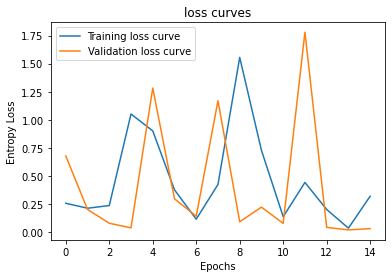

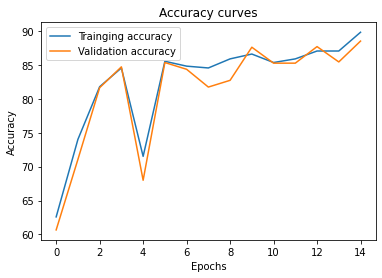

confusion_matrix 
 [[564  48]
 [ 21 627]]
f1_score 0.9478458049886621
Accuracy of the network on test images: 94 %


In [10]:
plot(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)
correct = 0
total = 0
tl=[]
pr=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in labels.tolist():
            tl.append(i)
        for j in predicted.tolist():
            pr.append(j)

    print("confusion_matrix \n",confusion_matrix(tl,pr))   
    print("f1_score",f1_score(tl,pr))
print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

# Resnet18

## PART 1



In [7]:
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [8]:
new_fc_resnet = [nn.Linear(512, 370), nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear(370, 2) ]
resnet18.fc = nn.Sequential(*new_fc_resnet)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Freeze training for all layers
for param in resnet18.parameters():
    param.requires_grad = False

In [0]:
for param in resnet18.fc.parameters():
     param.requires_grad = True

In [15]:
for param in resnet18.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True


In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [17]:
#Training
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
trainAccuracy =[]
validAccuracy = []
TrainLoss =[]
ValidLoss=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(resnet18.state_dict(), 'res18_FC_Only.pth')
    print("Training stats \n")
    tacc, tloss = getAccuracy(trainloader, "resnet")
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    print("validation stats\n")
    vacc , vloss = getAccuracy(validloader, "resnet")
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
    print("\n>>tacc, tloss, vacc , vloss\n",tacc, tloss, vacc , vloss ,"\n............................\n")
print('Finished Training')

Train Epoch: 0 [1008/1120 (90%)]	Loss: 0.656006: : 10it [00:27,  2.77s/it]


Training stats 

confusion_matrix
  [[108 372]
 [129 511]]
f1_score 0.6710439921208142
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[148 467]
 [ 99 392]]
f1_score 0.5807407407407408

>>tacc, tloss, vacc , vloss
 55.267857142857146 0.723550021648407 48.824593128390596 0.7892041206359863 
............................



Train Epoch: 1 [1008/1120 (90%)]	Loss: 0.677695: : 10it [00:27,  2.75s/it]


Training stats 

confusion_matrix
  [[110 370]
 [ 95 545]]
f1_score 0.7009646302250804
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[170 445]
 [ 58 433]]
f1_score 0.6325785244704164

>>tacc, tloss, vacc , vloss
 58.482142857142854 0.6823747754096985 54.520795660036164 0.7359848618507385 
............................



Train Epoch: 2 [1008/1120 (90%)]	Loss: 0.615561: : 10it [00:27,  2.74s/it]


Training stats 

confusion_matrix
  [[187 293]
 [113 527]]
f1_score 0.7219178082191781
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[212 403]
 [ 69 422]]
f1_score 0.6413373860182371

>>tacc, tloss, vacc , vloss
 63.75 0.6280485987663269 57.32368896925859 0.6493402719497681 
............................



Train Epoch: 3 [1008/1120 (90%)]	Loss: 0.566016: : 10it [00:27,  2.71s/it]


Training stats 

confusion_matrix
  [[242 238]
 [ 96 544]]
f1_score 0.7651195499296763
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[258 357]
 [ 62 429]]
f1_score 0.6718872357086924

>>tacc, tloss, vacc , vloss
 70.17857142857143 0.6007751226425171 62.11573236889693 0.686738908290863 
............................



Train Epoch: 4 [1008/1120 (90%)]	Loss: 0.568440: : 10it [00:27,  2.70s/it]


Training stats 

confusion_matrix
  [[257 223]
 [ 85 555]]
f1_score 0.7827926657263752
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[302 313]
 [ 77 414]]
f1_score 0.6798029556650246

>>tacc, tloss, vacc , vloss
 72.5 0.584376871585846 64.7377938517179 0.6505696773529053 
............................



Train Epoch: 5 [1008/1120 (90%)]	Loss: 0.524160: : 10it [00:27,  2.73s/it]


Training stats 

confusion_matrix
  [[275 205]
 [104 536]]
f1_score 0.776249094858798
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[294 321]
 [ 58 433]]
f1_score 0.6955823293172689

>>tacc, tloss, vacc , vloss
 72.41071428571429 0.5433686971664429 65.73236889692586 0.6688618063926697 
............................



Train Epoch: 6 [1008/1120 (90%)]	Loss: 0.558557: : 10it [00:27,  2.72s/it]


Training stats 

confusion_matrix
  [[317 163]
 [107 533]]
f1_score 0.7979041916167665
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[367 248]
 [ 75 416]]
f1_score 0.7203463203463204

>>tacc, tloss, vacc , vloss
 75.89285714285714 0.5324453711509705 70.79566003616637 0.6078562140464783 
............................



Train Epoch: 7 [1008/1120 (90%)]	Loss: 0.525938: : 10it [00:27,  2.72s/it]


Training stats 

confusion_matrix
  [[304 176]
 [ 96 544]]
f1_score 0.7999999999999998
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[357 258]
 [ 67 424]]
f1_score 0.7229326513213982

>>tacc, tloss, vacc , vloss
 75.71428571428571 0.5828296542167664 70.61482820976492 0.5583503246307373 
............................



Train Epoch: 8 [1008/1120 (90%)]	Loss: 0.532294: : 10it [00:27,  2.71s/it]


Training stats 

confusion_matrix
  [[303 177]
 [ 65 575]]
f1_score 0.8261494252873564
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[339 276]
 [ 59 432]]
f1_score 0.7206005004170142

>>tacc, tloss, vacc , vloss
 78.39285714285714 0.45286378264427185 69.71066907775769 0.634547770023346 
............................



Train Epoch: 9 [1008/1120 (90%)]	Loss: 0.542944: : 10it [00:27,  2.72s/it]


Training stats 

confusion_matrix
  [[341 139]
 [119 521]]
f1_score 0.8015384615384616
validation stats

confusion_matrix
  [[386 229]
 [ 79 412]]
f1_score 0.7279151943462898

>>tacc, tloss, vacc , vloss
 76.96428571428571 0.4931674599647522 72.15189873417721 0.5203860402107239 
............................

Finished Training


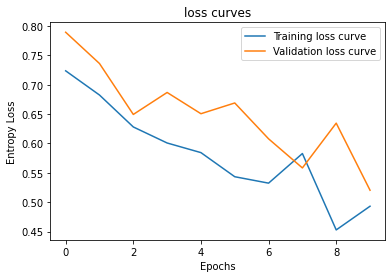

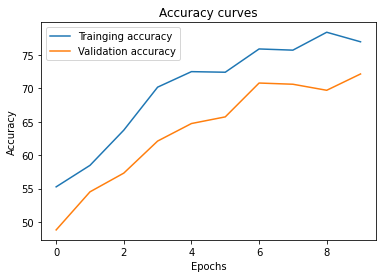

confusion_matrix 
 [[459 153]
 [ 74 574]]
f1_score 0.8349090909090908
Accuracy of the network on test images: 81 %


In [18]:
plot(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)
correct = 0
total = 0
tl=[]
pr=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in labels.tolist():
            tl.append(i)
        for j in predicted.tolist():
            pr.append(j)

    print("confusion_matrix \n",confusion_matrix(tl,pr))   
    print("f1_score",f1_score(tl,pr))
print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

## RESNET18 PART 2

#Layer 1 unfreezing

In [8]:
resnet18 = models.resnet18(pretrained=True)
new_fc_resnet = [nn.Linear(512, 370), nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear(370, 2) ]
resnet18.fc = nn.Sequential(*new_fc_resnet)
print(resnet18)
#..................................freezing/Unfreezing
for param in resnet18.parameters():
    param.requires_grad = False
for param in resnet18.fc.parameters():
    param.requires_grad = True
for param in resnet18.layer1.parameters():
    param.requires_grad = True
for param in resnet18.parameters(): #checking
    print(param.requires_grad)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [9]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
##Training
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
trainAccuracy =[]
validAccuracy = []
TrainLoss =[]
ValidLoss=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(resnet18.state_dict(), 'res18_entire.pth')
    print("Training stats \n")
    tacc, tloss = getAccuracy(trainloader, "resnet")
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    print("validation stats\n")
    vacc , vloss = getAccuracy(validloader, "resnet")
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
    print("\n>>tacc, tloss, vacc , vloss\n",tacc, tloss, vacc , vloss ,"\n............................\n")
print('Finished Training')

Train Epoch: 0 [372/1120 (99%)]	Loss: 0.859205: : 94it [00:27,  3.36it/s]


Training stats 

confusion_matrix
  [[335 145]
 [141 499]]
f1_score 0.7772585669781931
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[363 252]
 [101 390]]
f1_score 0.6884377758164165

>>tacc, tloss, vacc , vloss
 74.46428571428571 0.7702274322509766 68.08318264014467 0.45128610730171204 
............................



Train Epoch: 1 [372/1120 (99%)]	Loss: 0.358426: : 94it [00:27,  3.45it/s]


Training stats 

confusion_matrix
  [[352 128]
 [110 530]]
f1_score 0.8166409861325116
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[418 197]
 [ 81 410]]
f1_score 0.7468123861566484

>>tacc, tloss, vacc , vloss
 78.75 0.9148404002189636 74.86437613019892 0.4467822015285492 
............................



Train Epoch: 2 [372/1120 (99%)]	Loss: 0.391687: : 94it [00:26,  3.51it/s]


Training stats 

confusion_matrix
  [[322 158]
 [ 62 578]]
f1_score 0.8401162790697674
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[354 261]
 [ 55 436]]
f1_score 0.734006734006734

>>tacc, tloss, vacc , vloss
 80.35714285714286 0.3763788938522339 71.42857142857143 0.2940497398376465 
............................



Train Epoch: 3 [372/1120 (99%)]	Loss: 0.566955: : 94it [00:26,  3.52it/s]


Training stats 

confusion_matrix
  [[330 150]
 [ 63 577]]
f1_score 0.8441843452816387
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[384 231]
 [ 41 450]]
f1_score 0.7679180887372015

>>tacc, tloss, vacc , vloss
 80.98214285714286 0.9459535479545593 75.40687160940325 0.0710136890411377 
............................



Train Epoch: 4 [372/1120 (99%)]	Loss: 0.089296: : 94it [00:26,  3.57it/s]


Training stats 

confusion_matrix
  [[354 126]
 [ 80 560]]
f1_score 0.8446455505279035
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[417 198]
 [ 53 438]]
f1_score 0.7772848269742679

>>tacc, tloss, vacc , vloss
 81.60714285714286 0.15420374274253845 77.30560578661844 0.023322224617004395 
............................



Train Epoch: 5 [372/1120 (99%)]	Loss: 0.562893: : 94it [00:26,  3.55it/s]


Training stats 

confusion_matrix
  [[403  77]
 [143 497]]
f1_score 0.8187808896210873
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[489 126]
 [ 78 413]]
f1_score 0.8019417475728156

>>tacc, tloss, vacc , vloss
 80.35714285714286 0.6358200311660767 81.55515370705244 0.05461627244949341 
............................



Train Epoch: 6 [372/1120 (99%)]	Loss: 0.975404: : 94it [00:25,  3.62it/s]


Training stats 

confusion_matrix
  [[327 153]
 [ 45 595]]
f1_score 0.8573487031700289
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[370 245]
 [ 31 460]]
f1_score 0.7692307692307693

>>tacc, tloss, vacc , vloss
 82.32142857142857 0.5952813029289246 75.04520795660036 1.679892897605896 
............................



Train Epoch: 7 [372/1120 (99%)]	Loss: 0.107521: : 94it [00:26,  3.56it/s]


Training stats 

confusion_matrix
  [[410  70]
 [119 521]]
f1_score 0.8464662875710806
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[479 136]
 [ 86 405]]
f1_score 0.7848837209302326

>>tacc, tloss, vacc , vloss
 83.125 0.569248378276825 79.92766726943943 0.026104390621185303 
............................



Train Epoch: 8 [372/1120 (99%)]	Loss: 0.118626: : 94it [00:26,  3.56it/s]


Training stats 

confusion_matrix
  [[402  78]
 [114 526]]
f1_score 0.8456591639871383
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[468 147]
 [ 61 430]]
f1_score 0.8052434456928839

>>tacc, tloss, vacc , vloss
 82.85714285714286 0.3420374095439911 81.19349005424955 1.0699448585510254 
............................



Train Epoch: 9 [372/1120 (99%)]	Loss: 0.620143: : 94it [00:26,  3.58it/s]


Training stats 

confusion_matrix
  [[389  91]
 [ 92 548]]
f1_score 0.8569194683346364
validation stats

confusion_matrix
  [[464 151]
 [ 59 432]]
f1_score 0.8044692737430168

>>tacc, tloss, vacc , vloss
 83.66071428571429 0.2940358817577362 81.0126582278481 0.04570132493972778 
............................

Finished Training


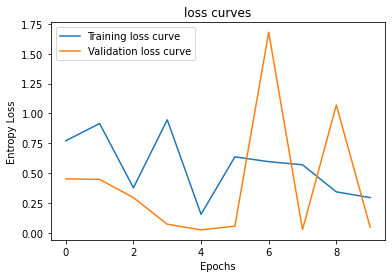

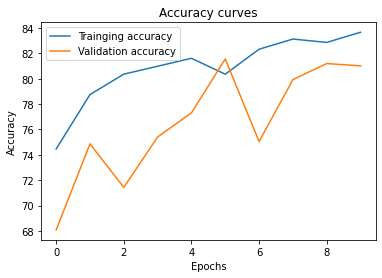

confusion_matrix 
 [[512 100]
 [ 40 608]]
f1_score 0.8967551622418879
Accuracy of the network on test images: 88 %


In [10]:
plot(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)
correct = 0
total = 0
tl=[]
pr=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in labels.tolist():
            tl.append(i)
        for j in predicted.tolist():
            pr.append(j)

    print("confusion_matrix \n",confusion_matrix(tl,pr))   
    print("f1_score",f1_score(tl,pr))
print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

with 2 layers unfreeze

In [6]:
resnet18 = models.resnet18(pretrained=True)
new_fc_resnet = [nn.Linear(512, 370), nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear(370, 2) ]
resnet18.fc = nn.Sequential(*new_fc_resnet)
print(resnet18)
#..................................freezing/Unfreezing
for param in resnet18.parameters():
    param.requires_grad = False
for param in resnet18.fc.parameters():
    param.requires_grad = True
for param in resnet18.layer1.parameters():
    param.requires_grad = True
for param in resnet18.layer2.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [7]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
##Training
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
trainAccuracy =[]
validAccuracy = []
TrainLoss =[]
ValidLoss=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(resnet18.state_dict(), 'res18_entire.pth')
    print("Training stats \n")
    tacc, tloss = getAccuracy(trainloader, "resnet")
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    print("validation stats\n")
    vacc , vloss = getAccuracy(validloader, "resnet")
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
    print("\n>>tacc, tloss, vacc , vloss\n",tacc, tloss, vacc , vloss ,"\n............................\n")
print('Finished Training')

Train Epoch: 0 [372/1120 (99%)]	Loss: 0.424732: : 94it [00:27,  3.37it/s]


Training stats 

confusion_matrix
  [[283 197]
 [ 91 549]]
f1_score 0.7922077922077922
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[331 284]
 [ 61 430]]
f1_score 0.7136929460580913

>>tacc, tloss, vacc , vloss
 74.28571428571429 0.9421663284301758 68.80650994575045 0.7126232385635376 
............................



Train Epoch: 1 [372/1120 (99%)]	Loss: 0.943623: : 94it [00:27,  3.44it/s]


Training stats 

confusion_matrix
  [[356 124]
 [ 94 546]]
f1_score 0.833587786259542
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[417 198]
 [ 70 421]]
f1_score 0.7585585585585586

>>tacc, tloss, vacc , vloss
 80.53571428571429 0.8043718338012695 75.76853526220614 0.6631403565406799 
............................



Train Epoch: 2 [372/1120 (99%)]	Loss: 0.569051: : 94it [00:26,  3.55it/s]


Training stats 

confusion_matrix
  [[407  73]
 [117 523]]
f1_score 0.8462783171521037
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[478 137]
 [ 77 414]]
f1_score 0.7946257197696737

>>tacc, tloss, vacc , vloss
 83.03571428571429 0.4023812413215637 80.6509945750452 0.09056687355041504 
............................



Train Epoch: 3 [372/1120 (99%)]	Loss: 0.597590: : 94it [00:25,  3.62it/s]


Training stats 

confusion_matrix
  [[374 106]
 [ 80 560]]
f1_score 0.8575803981623278
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[438 177]
 [ 56 435]]
f1_score 0.7887579329102448

>>tacc, tloss, vacc , vloss
 83.39285714285714 0.3950701951980591 78.93309222423146 1.3209459781646729 
............................



Train Epoch: 4 [372/1120 (99%)]	Loss: 0.805936: : 94it [00:27,  3.47it/s]


Training stats 

confusion_matrix
  [[385  95]
 [ 88 552]]
f1_score 0.8578088578088578
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[463 152]
 [ 65 426]]
f1_score 0.7970065481758652

>>tacc, tloss, vacc , vloss
 83.66071428571429 0.1890498697757721 80.37974683544304 1.0751498937606812 
............................



Train Epoch: 5 [372/1120 (99%)]	Loss: 0.579469: : 94it [00:26,  3.57it/s]


Training stats 

confusion_matrix
  [[343 137]
 [ 49 591]]
f1_score 0.8640350877192982
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[375 240]
 [ 31 460]]
f1_score 0.7724601175482787

>>tacc, tloss, vacc , vloss
 83.39285714285714 0.40909457206726074 75.49728752260398 1.7633827924728394 
............................



Train Epoch: 6 [372/1120 (99%)]	Loss: 0.637803: : 94it [00:25,  3.63it/s]


Training stats 

confusion_matrix
  [[330 150]
 [ 33 607]]
f1_score 0.8690050107372942
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[362 253]
 [ 27 464]]
f1_score 0.7682119205298014

>>tacc, tloss, vacc , vloss
 83.66071428571429 0.18112866580486298 74.68354430379746 0.24253876507282257 
............................



Train Epoch: 7 [372/1120 (99%)]	Loss: 0.201922: : 94it [00:25,  3.65it/s]


Training stats 

confusion_matrix
  [[296 184]
 [ 16 624]]
f1_score 0.861878453038674
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[321 294]
 [ 28 463]]
f1_score 0.7419871794871794

>>tacc, tloss, vacc , vloss
 82.14285714285714 0.20484702289104462 70.88607594936708 0.23262977600097656 
............................



Train Epoch: 8 [372/1120 (99%)]	Loss: 0.440139: : 94it [00:25,  3.65it/s]


Training stats 

confusion_matrix
  [[385  95]
 [ 70 570]]
f1_score 0.8735632183908045
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[471 144]
 [ 52 439]]
f1_score 0.8175046554934824

>>tacc, tloss, vacc , vloss
 85.26785714285714 0.28623098134994507 82.27848101265823 0.0192297101020813 
............................



Train Epoch: 9 [372/1120 (99%)]	Loss: 1.076115: : 94it [00:25,  3.65it/s]


Training stats 

confusion_matrix
  [[387  93]
 [ 67 573]]
f1_score 0.8774885145482388
validation stats

confusion_matrix
  [[465 150]
 [ 46 445]]
f1_score 0.8195211786372006

>>tacc, tloss, vacc , vloss
 85.71428571428571 1.0972754955291748 82.27848101265823 0.21886612474918365 
............................

Finished Training


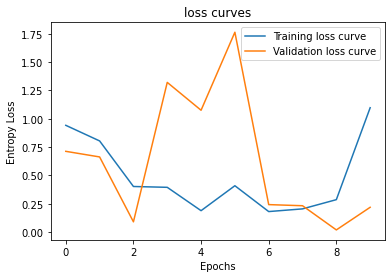

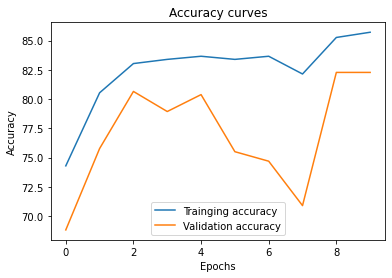

confusion_matrix 
 [[512 100]
 [ 29 619]]
f1_score 0.9056327724945137
Accuracy of the network on test images: 89 %


In [8]:
plot(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)
correct = 0
total = 0
tl=[]
pr=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in labels.tolist():
            tl.append(i)
        for j in predicted.tolist():
            pr.append(j)

    print("confusion_matrix \n",confusion_matrix(tl,pr))   
    print("f1_score",f1_score(tl,pr))
print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

## All unfreezed layers

In [6]:
resnet18 = models.resnet18(pretrained=True)
new_fc_resnet = [nn.Linear(512, 370), nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear(370, 2) ]
resnet18.fc = nn.Sequential(*new_fc_resnet)
print(resnet18)
#..................................freezing/Unfreezing
for param in resnet18.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [7]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
##Training
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
trainAccuracy =[]
validAccuracy = []
TrainLoss =[]
ValidLoss=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(resnet18.state_dict(), 'res18_entire.pth')
    print("Training stats \n")
    tacc, tloss = getAccuracy(trainloader, "resnet")
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    print("validation stats\n")
    vacc , vloss = getAccuracy(validloader, "resnet")
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
    print("\n>>tacc, tloss, vacc , vloss\n",tacc, tloss, vacc , vloss ,"\n............................\n")
print('Finished Training')

Train Epoch: 0 [372/1120 (99%)]	Loss: 0.254089: : 94it [00:37,  2.49it/s]


Training stats 

confusion_matrix
  [[356 124]
 [ 92 548]]
f1_score 0.8353658536585366
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[414 201]
 [ 60 431]]
f1_score 0.7675868210151381

>>tacc, tloss, vacc , vloss
 80.71428571428571 0.7803592085838318 76.4014466546112 0.8109266757965088 
............................



Train Epoch: 1 [372/1120 (99%)]	Loss: 0.220562: : 94it [00:37,  2.48it/s]


Training stats 

confusion_matrix
  [[373 107]
 [117 523]]
f1_score 0.8236220472440945
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[464 151]
 [ 63 428]]
f1_score 0.7999999999999999

>>tacc, tloss, vacc , vloss
 80.0 0.6549994945526123 80.6509945750452 0.756316065788269 
............................



Train Epoch: 2 [372/1120 (99%)]	Loss: 0.274022: : 94it [00:38,  2.47it/s]


Training stats 

confusion_matrix
  [[374 106]
 [ 61 579]]
f1_score 0.8739622641509434
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[450 165]
 [ 40 451]]
f1_score 0.8148148148148148

>>tacc, tloss, vacc , vloss
 85.08928571428571 0.5261401534080505 81.46473779385171 0.055258333683013916 
............................



Train Epoch: 3 [372/1120 (99%)]	Loss: 0.978696: : 94it [00:37,  2.49it/s]


Training stats 

confusion_matrix
  [[393  87]
 [ 80 560]]
f1_score 0.8702408702408703
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[477 138]
 [ 50 441]]
f1_score 0.8242990654205609

>>tacc, tloss, vacc , vloss
 85.08928571428571 0.04641151428222656 83.00180831826401 0.13873523473739624 
............................



Train Epoch: 4 [372/1120 (99%)]	Loss: 0.477667: : 94it [00:37,  2.50it/s]


Training stats 

confusion_matrix
  [[391  89]
 [ 86 554]]
f1_score 0.8636009353078722
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[499 116]
 [ 53 438]]
f1_score 0.8382775119617226

>>tacc, tloss, vacc , vloss
 84.375 0.18950378894805908 84.71971066907776 0.09609967470169067 
............................



Train Epoch: 5 [372/1120 (99%)]	Loss: 0.699997: : 94it [00:37,  2.51it/s]


Training stats 

confusion_matrix
  [[402  78]
 [ 80 560]]
f1_score 0.8763693270735524
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[484 131]
 [ 45 446]]
f1_score 0.8352059925093633

>>tacc, tloss, vacc , vloss
 85.89285714285714 0.16983094811439514 84.08679927667269 1.1412954330444336 
............................



Train Epoch: 6 [372/1120 (99%)]	Loss: 1.332770: : 94it [00:37,  2.49it/s]


Training stats 

confusion_matrix
  [[404  76]
 [ 89 551]]
f1_score 0.8697711128650355
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[505 110]
 [ 57 434]]
f1_score 0.8386473429951691

>>tacc, tloss, vacc , vloss
 85.26785714285714 1.1717529296875 84.9005424954792 0.28971123695373535 
............................



Train Epoch: 7 [372/1120 (99%)]	Loss: 0.180299: : 94it [00:37,  2.50it/s]


Training stats 

confusion_matrix
  [[398  82]
 [ 54 586]]
f1_score 0.8960244648318044
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[463 152]
 [ 42 449]]
f1_score 0.8223443223443224

>>tacc, tloss, vacc , vloss
 87.85714285714286 0.11977428197860718 82.45931283905968 1.0821058750152588 
............................



Train Epoch: 8 [372/1120 (99%)]	Loss: 0.130044: : 94it [00:37,  2.51it/s]


Training stats 

confusion_matrix
  [[404  76]
 [ 66 574]]
f1_score 0.889922480620155
validation stats



0it [00:00, ?it/s]

confusion_matrix
  [[488 127]
 [ 49 442]]
f1_score 0.8339622641509434

>>tacc, tloss, vacc , vloss
 87.32142857142857 0.06852023303508759 84.08679927667269 0.03719526529312134 
............................



Train Epoch: 9 [372/1120 (99%)]	Loss: 0.084847: : 94it [00:37,  2.50it/s]


Training stats 

confusion_matrix
  [[404  76]
 [ 66 574]]
f1_score 0.889922480620155
validation stats

confusion_matrix
  [[481 134]
 [ 43 448]]
f1_score 0.8350419384902144

>>tacc, tloss, vacc , vloss
 87.32142857142857 1.019882321357727 83.99638336347198 0.4944244623184204 
............................

Finished Training


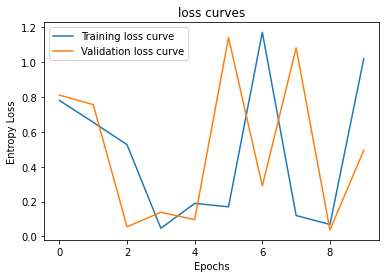

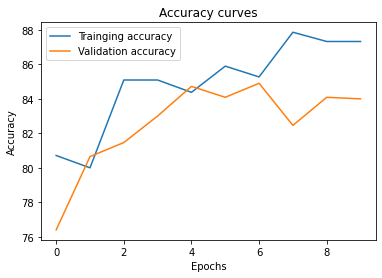

confusion_matrix 
 [[540  72]
 [ 31 617]]
f1_score 0.9229618548990277
Accuracy of the network on test images: 91 %


In [8]:
plot(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)
correct = 0
total = 0
tl=[]
pr=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in labels.tolist():
            tl.append(i)
        for j in predicted.tolist():
            pr.append(j)

    print("confusion_matrix \n",confusion_matrix(tl,pr))   
    print("f1_score",f1_score(tl,pr))
print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))